In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path
from typing import Literal, List, Tuple
import matplotlib.pyplot as plt
from collections import defaultdict
import logging
import seaborn as sns

import IPython
import numpy as np
import pandas as pd
from IPython.display import display

notebook_path = Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"])
project_dir = notebook_path.parent.parent
sys.path.append(str(project_dir))


import src.utils.custom_log as custom_log
from src.utils.Csv import Csv
from src.utils.set_rcparams import set_rcparams

os.chdir(project_dir)
LOG = logging.getLogger(__name__)
custom_log.init_logger(log_lvl=logging.INFO)
LOG.info("Start in %s", Path().cwd())
set_rcparams()
B_PATH: Path = Path("/mnt") / "q" / "Val_Chain_Sims" / "AB_Testing"
LOG.info("B_PATH: %s", B_PATH)
B_PATH.is_dir()

2024-12-17 21:24:17,188     INFO  MainProcess  MainThread Start in /root/py_projects/aihiii
2024-12-17 21:24:17,190     INFO  MainProcess  MainThread Setting rcparams for matplotlib
2024-12-17 21:24:17,244     INFO  MainProcess  MainThread Using style src/visualization/dissertation.mplstyle
2024-12-17 21:24:17,246     INFO  MainProcess  MainThread B_PATH: /mnt/q/Val_Chain_Sims/AB_Testing


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [3]:
def get_data() -> Tuple[pd.DataFrame, List[str]]:
    db = defaultdict(list)
    cases = set([])
    for file in B_PATH.rglob("mes0000"):
        if not file.parent.parent.stem.startswith("Assemblies"):
            continue
        LOG.info("Read: %s", file)
        # read file
        with open(file) as f:
            c = f.readlines()

        # get from file end
        for line in reversed(c):
            if line.startswith(" Elapsed time"):
                parts = line.split()
                db["Time [min]"].append(float(parts[2]) / 60)
                db["Procs"].append({94: 96, 96: 96, 48: 48}[int(parts[-3])])
                db["Load Case"].append(file.parent.name.replace("_", " "))
                db["Case"].append(" ".join(file.parent.parent.parent.name.split("_")[1:]))
                cases.add(file.parent.parent.parent.name)
                db["Path"].append(file.relative_to(B_PATH).parent)
                break

        # get from file start
        for line in reversed(c):
            if line.startswith("     |  Version : "):
                parts = line.split()

                db["Precision"].append(parts[4])
                db["Version"].append(parts[5])
                db["Parallelization"].append(parts[3])

        # combine
        db["Config"].append(f"{db['Precision'][-1].upper()}P {db['Procs'][-1]}")

        LOG.debug("From %s got %s", file, [(x, db[x][-1]) for x in db.keys()])

    # consolidate
    db = pd.DataFrame(db)
    cases = [" ".join(x.split("_")[1:]) for x in sorted(cases)]
    LOG.info("Got %s", db.shape)
    return db, cases


DB, CASES = get_data()
display(DB)
print(CASES)

2024-12-17 21:24:24,115     INFO  MainProcess  MainThread Read: /mnt/q/Val_Chain_Sims/AB_Testing/000_Base_Model/Assemblies_1/Full_Frontal/mes0000
2024-12-17 21:24:25,148     INFO  MainProcess  MainThread Read: /mnt/q/Val_Chain_Sims/AB_Testing/000_Base_Model/Assemblies_1/Moderate_Overlap_Left/mes0000
2024-12-17 21:24:27,376     INFO  MainProcess  MainThread Read: /mnt/q/Val_Chain_Sims/AB_Testing/000_Base_Model/Assemblies_1/Moderate_Overlap_Right/mes0000
2024-12-17 21:24:29,494     INFO  MainProcess  MainThread Read: /mnt/q/Val_Chain_Sims/AB_Testing/000_Base_Model/Assemblies_1/Oblique_Left/mes0000
2024-12-17 21:24:32,915     INFO  MainProcess  MainThread Read: /mnt/q/Val_Chain_Sims/AB_Testing/000_Base_Model/Assemblies_1/Oblique_Right/mes0000
2024-12-17 21:24:36,484     INFO  MainProcess  MainThread Read: /mnt/q/Val_Chain_Sims/AB_Testing/000_Base_Model/Assemblies_2/Full_Frontal/mes0000
2024-12-17 21:24:37,841     INFO  MainProcess  MainThread Read: /mnt/q/Val_Chain_Sims/AB_Testing/000_Bas

,Time [min],Procs,Load Case,Case,Path,Precision,Version,Parallelization,Config
0,635.816667,48,Full Frontal,Base Model,000_Base_Model/Assemblies_1/Full_Frontal,s,R12.0.0,mpp,SP 48
1,811.716667,48,Moderate Overlap Left,Base Model,000_Base_Model/Assemblies_1/Moderate_Overlap_Left,s,R12.0.0,mpp,SP 48
2,793.550000,48,Moderate Overlap Right,Base Model,000_Base_Model/Assemblies_1/Moderate_Overlap_R...,s,R12.0.0,mpp,SP 48
3,886.066667,48,Oblique Left,Base Model,000_Base_Model/Assemblies_1/Oblique_Left,s,R12.0.0,mpp,SP 48
4,869.033333,48,Oblique Right,Base Model,000_Base_Model/Assemblies_1/Oblique_Right,s,R12.0.0,mpp,SP 48
...,...,...,...,...,...,...,...,...,...
136,14.916667,48,Moderate Overlap Left,Carpet Rigid,990_Carpet_Rigid/Assemblies_3/Moderate_Overlap...,d,R12.0.0,mpp,DP 48
137,15.000000,48,Moderate Overlap Right,Carpet Rigid,990_Carpet_Rigid/Assemblies_3/Moderate_Overlap...,d,R12.0.0,mpp,DP 48
138,2342.683333,96,Full Frontal,Carpet Rigid,990_Carpet_Rigid/Assemblies_4/Full_Frontal,d,R12.0.0,mpp,DP 96
139,1467.500000,96,Moderate Overlap Left,Carpet Rigid,990_Carpet_Rigid/Assemblies_4/Moderate_Overlap...,d,R12.0.0,mpp,DP 96


['Base Model', 'Guided BIW', 'PAB Simplified', 'Seat Simplified', '900 NoIntrusion', 'HIII', 'NoCAB', 'NoDoor', 'Simplified Belt', 'Simplified BIW', 'NoIntrusion', 'Dash Rigid', 'Carpet Rigid']


Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.
findfont: Matching TeX Gyre Heros:style=normal:variant=normal:weight=normal:stretch=normal:size=8.0.
findfont: score(FontEntry(fname='c:\\Users\\plaschkies\\Documents\\Py_Projects\\aihiii\\.conda\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='c:\\Users\\plaschkies\\Documents\\Py_Projects\\aihiii\\.conda\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='c:\\Users\\plaschkies\\Documents\\Py_Projects\\aihiii\\.conda\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Oblique.

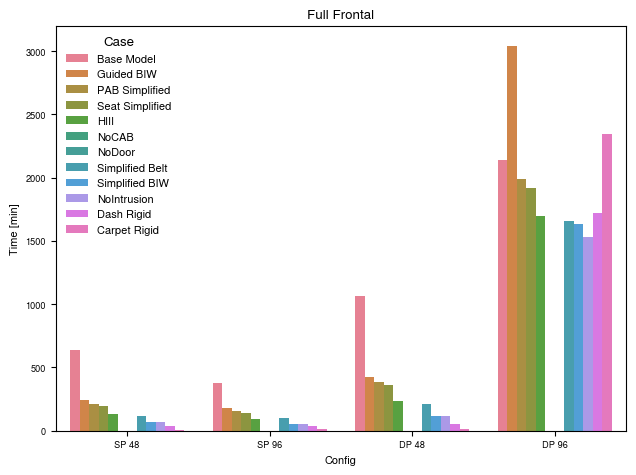

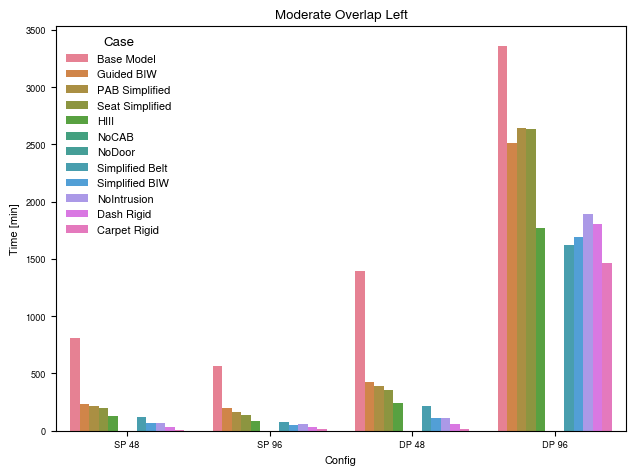

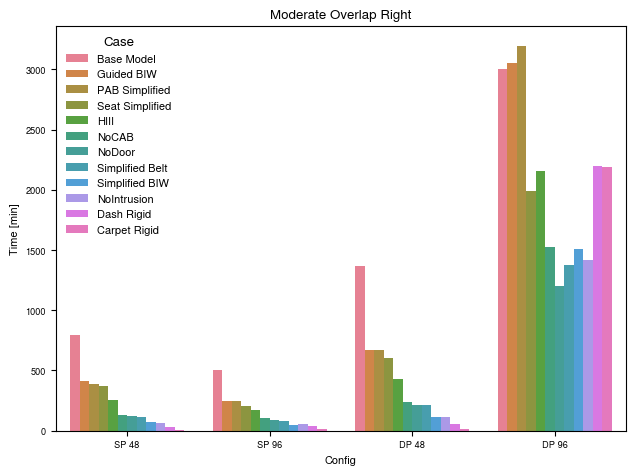

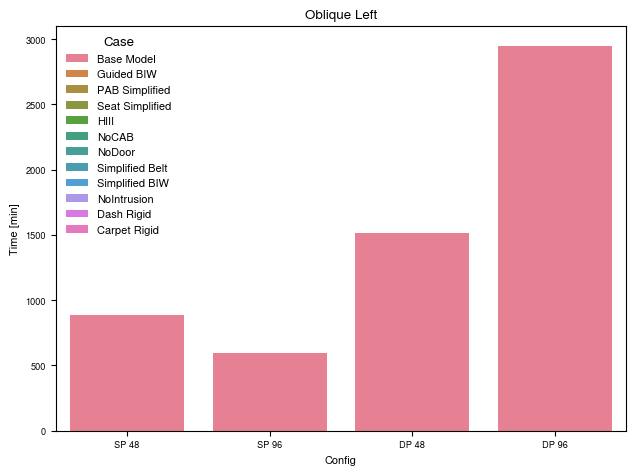

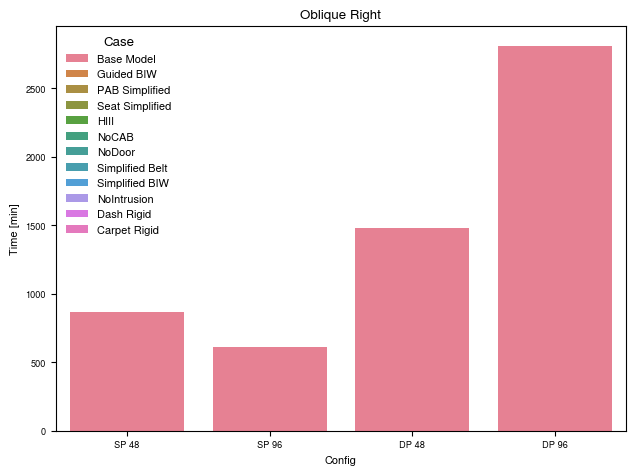

In [5]:
for load_case in DB["Load Case"].unique():
    fig, ax = plt.subplots()
    sns.barplot(data=DB[DB["Load Case"].eq(load_case)], x="Config", y="Time [min]", hue="Case", ax=ax, hue_order=CASES)
    plt.title(load_case)

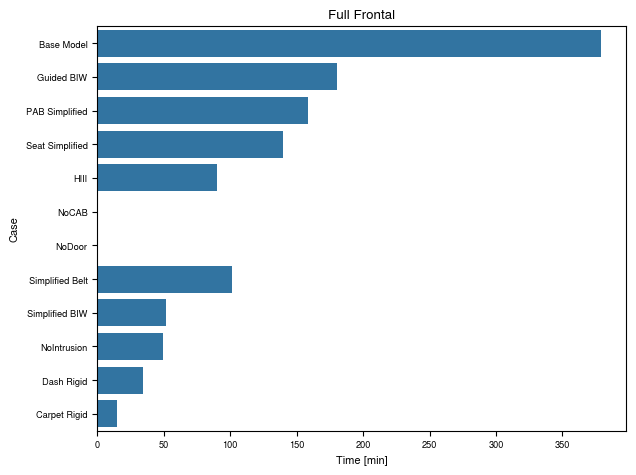

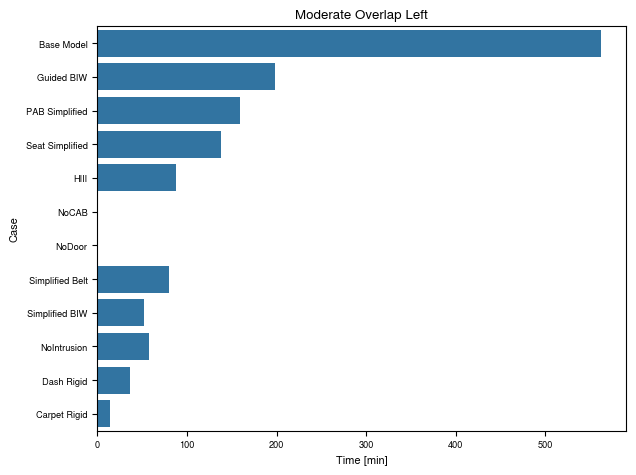

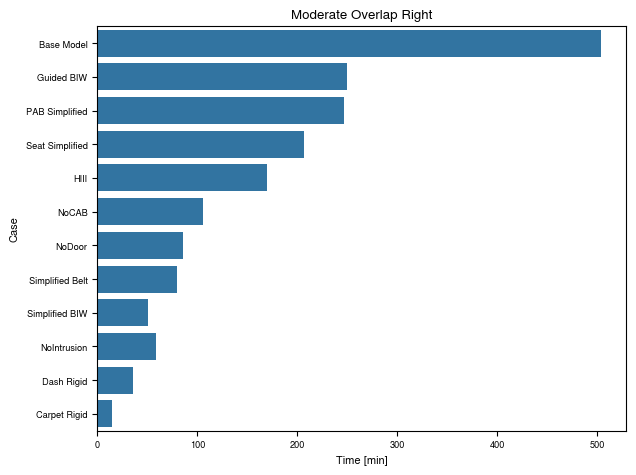

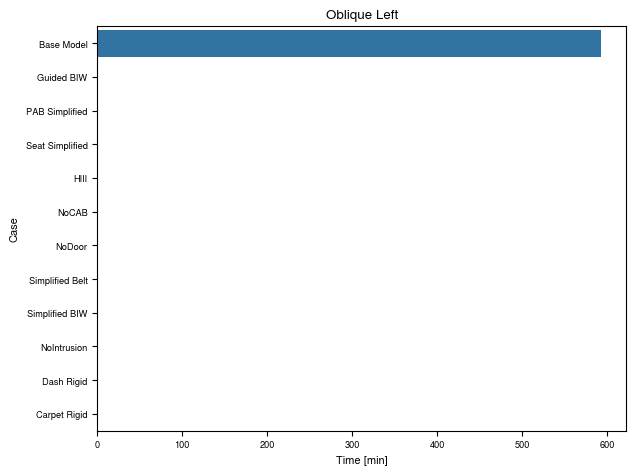

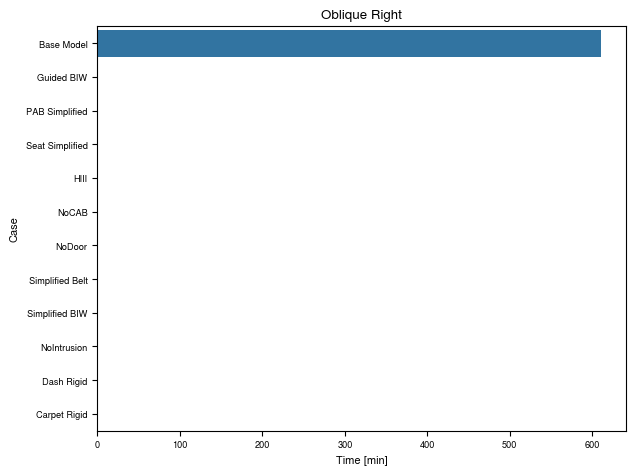

In [6]:
for load_case in DB["Load Case"].unique():
    fig, ax = plt.subplots()
    sns.barplot(data=DB[DB["Load Case"].eq(load_case) & DB["Config"].eq("SP 96")], y="Case", x="Time [min]", ax=ax, order=CASES)
    plt.title(load_case)

In [32]:
display(DB[["Time [min]", "Case"]][DB["Load Case"].eq("Full Frontal") | DB["Load Case"].eq("Moderate Overlap Left")| DB["Load Case"].eq("Moderate Overlap Right")].groupby("Case").median())

,Time [min]
Case,
Base Model,940.258333
Carpet Rigid,14.883333
Dash Rigid,45.516667
Guided BIW,417.558333
HIII,237.991667
NoCAB,187.475000
NoDoor,164.908333
NoIntrusion,88.158333
PAB Simplified,386.775000


In [8]:
DB[DB["Case"].eq("Base Model")].describe()

,Time [min],Procs
count,20.000000,20.00000
mean,1387.129167,72.00000
std,950.616583,24.62348
min,378.850000,48.00000
25%,629.416667,48.00000
50%,977.433333,72.00000
75%,1671.483333,96.00000
max,3361.616667,96.00000


<Axes: ylabel='Frequency'>

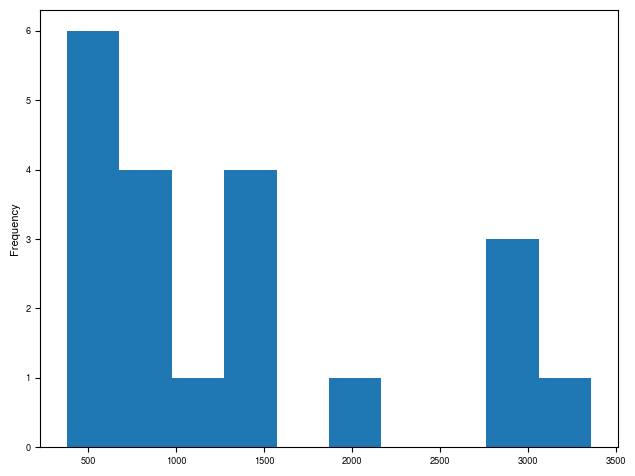

In [9]:
DB["Time [min]"][DB["Case"].eq("Base Model")].plot.hist()

<Axes: ylabel='Time [min]'>

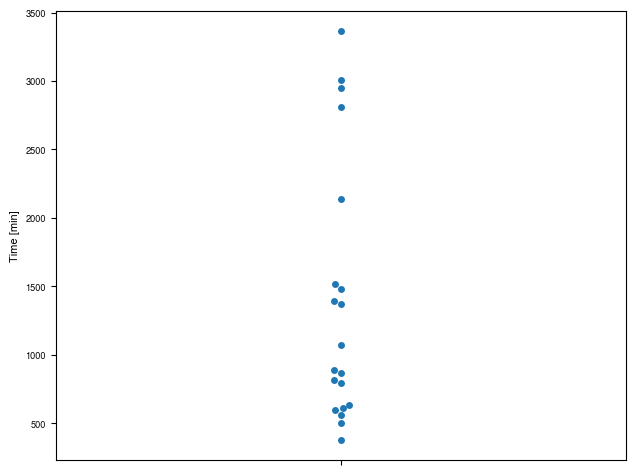

In [10]:
sns.swarmplot(DB["Time [min]"][DB["Case"].eq("Base Model")])

/tmp/ipykernel_1661939/1239219665.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(
2024-12-17 22:07:02,725     INFO  MainProcess  MainThread maxp pruned
2024-12-17 22:07:02,733     INFO  MainProcess  MainThread cmap pruned
2024-12-17 22:07:02,734     INFO  MainProcess  MainThread post pruned
2024-12-17 22:07:02,737     INFO  MainProcess  MainThread CFF  pruned
2024-12-17 22:07:02,744     INFO  MainProcess  MainThread GPOS pruned
2024-12-17 22:07:02,760     INFO  MainProcess  MainThread GSUB pruned
2024-12-17 22:07:02,764     INFO  MainProcess  MainThread Added .notdef to subset
2024-12-17 22:07:02,769     INFO  MainProcess  MainThread Closing glyph list over 'GSUB': 48 glyphs before
2024-12-17 22:07:02,770     INFO  MainProcess  MainThread Glyph names: ['.notdef', 'B', 'C', 'D', 'F', 'L', 'M', 'O', 'P', 'R', 'S', 'T', 'W', 'a', 'ampersand', 'b', 'bracketleft', 'bracketright', 

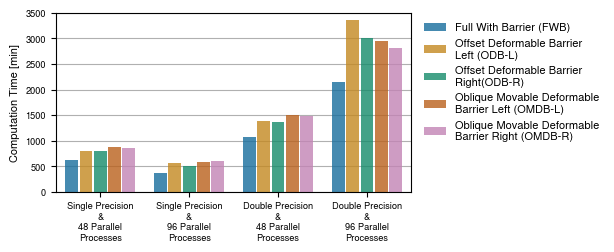

In [26]:
fig_width: float = (448.13095 / 72)-0.2
fig_height: float = 0.4 * fig_width
names = {
    "Full Frontal": "Full With Barrier (FWB)",
    "Moderate Overlap Left": "Offset Deformable Barrier\nLeft (ODB-L)",
    "Moderate Overlap Right": "Offset Deformable Barrier\nRight(ODB-R)",
    "Oblique Left": "Oblique Movable Deformable\nBarrier Left (OMDB-L)",
    "Oblique Right": "Oblique Movable Deformable\nBarrier Right (OMDB-R)",
}
fig, ax = plt.subplots(layout="constrained", ncols=2, width_ratios=[1, 0.1])
g = sns.barplot(
    data=DB[DB["Case"].eq("Base Model")].replace(names),
    x="Config",
    y="Time [min]",
    hue="Load Case",
    gap=0.1,
    ax=ax[0],
    palette="colorblind",
    alpha=0.8,
)
ax[0].grid(axis="y")
ax[0].set_ylim([0, 3500])
ax[0].set_yticks(np.arange(0, 3501, 500))
ax[0].set_axisbelow(b=True)
g.legend_.set_title(None)

ax[1].legend(*ax[0].get_legend_handles_labels(), loc="upper center")
ax[1].axis("off")
ax[0].get_legend().remove()
#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax[0].set_ylabel("Computation Time [min]")
#ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[0].set_xticklabels(
    [
        "Single Precision\n&\n48 Parallel\nProcesses",
        "Single Precision\n&\n96 Parallel\nProcesses",
        "Double Precision\n&\n48 Parallel\nProcesses",
        "Double Precision\n&\n96 Parallel\nProcesses",
    ]
)
ax[0].set_xlabel("")
fig.set_figheight(fig_height)
fig.set_figwidth(fig_width)
fig.savefig(Path("reports") / "Runtime_Base.pdf")